# Generating Data

In [2]:
using Random, Distributions, DifferentialEquations, Plots, LinearAlgebra

Random.seed!(12)
num_observations = 3
clusters = 1
dim = 10
spread = 10
margin = rand(0:10,dim)*50

C = Diagonal(ones(dim))
x1, x2 = rand(MvNormal(rand(0:spread,dim), C), num_observations), rand(MvNormal(rand(0:spread,dim), C), num_observations)

for i in 1:clusters
    if i == 1
        x1 = transpose(rand(MvNormal(rand(0:spread,dim) + margin, C), num_observations))
        x2 = transpose(rand(MvNormal(rand(0:spread,dim), C), num_observations))
    else
        x1_temp = transpose(rand(MvNormal(rand(0:spread,dim) + margin, C), num_observations))
        x1 = cat(x1, x1_temp)
        x2_temp = transpose(rand(MvNormal(rand(0:spread,dim), C), num_observations))
        x2 = cat(x2_temp)
    end
end

simulated_separableish_features = vcat(x1,x2)
simulated_labels = vcat(zeros(size(x1)[1]), ones(size(x2)[1]))
simulated_labels = reshape(simulated_labels,(length(simulated_labels),1))
intercept = ones(size(simulated_separableish_features)[1], 1)
simulated_separableish_features = hcat(intercept, simulated_separableish_features)
dim+=1

11

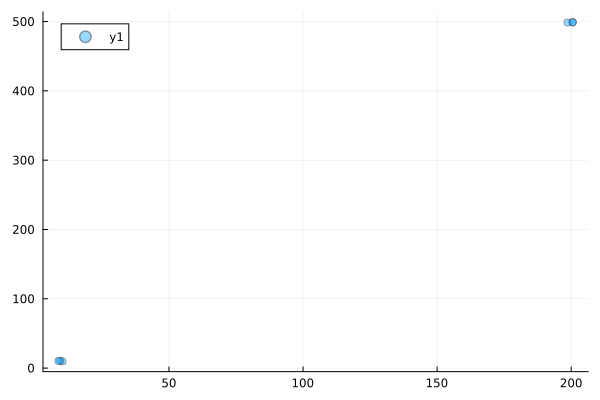

In [3]:
scatter(simulated_separableish_features[:,6], simulated_separableish_features[:,3], ma=0.4)

In [1]:
K=4

function grad(X, Y, w)
    pred = X * w - Y
    return vec(transpose((pred).^(K-1)) * X)
end

function loss(X, Y, w)
    pred = Y - X * w
    return (1 / K) * sum(pred.^K)
end


loss (generic function with 1 method)

# GD and Nesterov's accelerated gradient mathod

In [11]:
function gd(f, df, num_steps, lr, inits, period)
    losses = zeros(Int(num_steps/period))
    weights = inits
    for step in 1:num_steps
        gradient = -df(weights)
        weights += lr * gradient
        if step%period == 0
            losses[Int(step/period)] = f(weights)[1]
        end
        if step % (Int(num_steps/20)) == 0
            println(losses[Int(step/period)])
        end
    end
    return weights, losses
end

weights = zeros(dim)
f = x->loss(simulated_separableish_features, simulated_labels, x)
df = x->grad(simulated_separableish_features, simulated_labels, x)
wieghts, losses = gd(f, df, 1e6, 3e-6, weights, 100)


4.2788830451934214e-5
1.3163238370526057e-5
8.041808349855707e-6
6.739269312101455e-6
6.3383211544158265e-6
6.175265845599501e-6
6.078249900617466e-6
6.000847898269133e-6
5.930253725998495e-6
5.862859576244289e-6
5.797606951382531e-6
5.734152389848076e-6
5.672356136159831e-6
5.612138184364883e-6
5.553437320641374e-6
5.496199313156245e-6
5.440373427691151e-6
5.385911345294548e-6
5.332766781440894e-6
5.280895314057638e-6


([0.00517127278583557, 0.03385339109790772, 0.0004485086792319806, 0.0034100277042681537, 0.0021417515802485713, 0.027963170974407592, 0.031437392898271375, 0.029301294217048465, -0.0273445300115486, -0.02343733223443635, 0.00037593050528226575], [0.40968672825175556, 0.26049686784979476, 0.180310744612391, 0.13227962470770646, 0.10123962869754628, 0.08001958598908854, 0.06486982728511877, 0.05367444278200342, 0.04516569238524267, 0.03854632681958522  …  5.281818000503631e-6, 5.281715460095268e-6, 5.281612924610482e-6, 5.281510394049372e-6, 5.281407868411599e-6, 5.281305347696481e-6, 5.281202831903887e-6, 5.2811003210332655e-6, 5.280997815084805e-6, 5.280895314057638e-6])

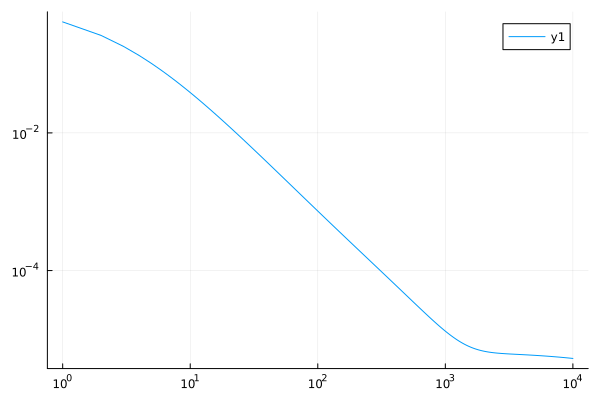

In [12]:
plot(losses, xaxis=:log, yaxis=:log)

In [13]:
print(losses[length(losses)])

5.280895314057638e-6

In [14]:
function nag(f, df, num_steps, lr, inits, period)
    losses = zeros(Int(num_steps/period))
    x = inits
    x_prev = inits
    y = inits
    for k in 1:num_steps
        x_prev = x
        x = y - lr * df(y)
        y = x + (k-2) / (k+1.0) * (x-x_prev)
        if k%period == 0
            losses[Int(k/period)] = f(x)[1]
        end
        if k % (Int(num_steps/20)) == 0
            print(losses[Int(k/period)])
            print("\n")
        end
    end
    return x, losses
end

weights = zeros(dim,1)
f = x->loss(simulated_separableish_features, simulated_labels, x)
df = x->grad(simulated_separableish_features, simulated_labels, x)

wieghts, losses = nag(f, df, 1e6, 1e-6, weights, 100)

4.769655241291721e-7
5.4520859742737026e-8
6.954221047849163e-9
1.1450164331236214e-9
2.659434111720222e-10
7.575775156824596e-11
2.4216086189031217e-11
8.565132519287477e-12
3.3957296223189048e-12
1.5201659310450463e-12
7.640305408406476e-13
4.231558561917614e-13
2.535468310570143e-13
1.608357182347513e-13
1.0674563486253418e-13
7.357720667988859e-14
5.2313423434718616e-14
3.8278639112261395e-14
2.8838828172665543e-14
2.237352636962747e-14


([0.011495908759249553; 0.07827037806198209; … ; -0.030286351935557662; -0.005817576792164086;;], [0.08580177126856736, 0.004014569436758913, 0.0004158108313909404, 8.749230391562228e-5, 2.868623297732461e-5, 1.3075949011393154e-5, 8.388965594119192e-6, 7.276311442499705e-6, 7.432265114420369e-6, 7.967502418661769e-6  …  2.247024243287331e-14, 2.2459465293839588e-14, 2.244869589505996e-14, 2.243793423171989e-14, 2.2427180297853186e-14, 2.241643408710253e-14, 2.2405695594758084e-14, 2.239496481482564e-14, 2.2384241741139823e-14, 2.237352636962747e-14])

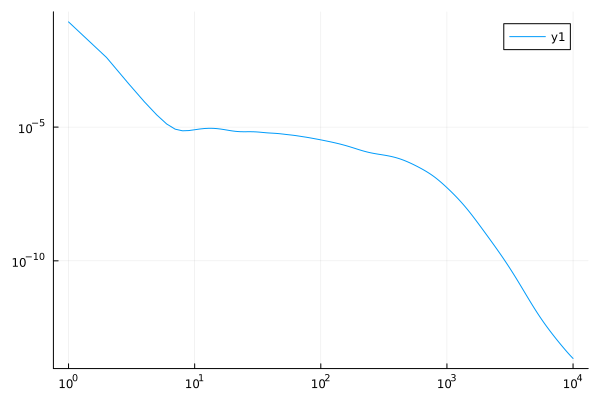

In [15]:
plot(losses, xaxis=:log, yaxis=:log)

In [16]:
print(losses[length(losses)])

2.237352636962747e-14

# ODE Simulation

In [17]:
f = x->loss(simulated_separableish_features, simulated_labels, x)
df = x->grad(simulated_separableish_features, simulated_labels, x)

function ODE(du, u, p, t)
    return -(2*p[1]+1) / t * du - p[1]^2 * t^(p[1]-2) * df(u)
end

function simulate(p, s, N, period, step, xinit, vinit)
    h = step
    if s==1
        alg = Euler()
    elseif s==2
        alg = Midpoint()
    elseif s==4
        alg = RK4()
    elseif s==8
        alg = DP8()
    else
        return nothing
    end
    x = xinit
    v = vinit
    loop = Int(N/period)
    losses = zeros(loop)

    soln=nothing
    
    for j in 1:loop
        losses[j] = f(x)[1]
        if j%1000 == 0
            println("Loop="*string(j)*"\t Loss="*string(losses[j]))
        end
        t_start = 0.01 + (j-1)*h*period
        t_end = 0.01 + j*h*period
        tspan = (t_start, t_end)
        prob = SecondOrderODEProblem(ODE, v, x, tspan, p)
        soln = solve(prob, alg, dt=h, adaptive=false)
        x = soln[12:22, period+1]
        v = soln[1:11, period+1]
    end
    return losses, soln
end

simulate (generic function with 1 method)

In [19]:
N = Int(1e6)
truncate = 0
period = 100

svals = [4,4,4,4]
pvals = [2,4,6,8]
steps = [1e-4, 1e-4, 1e-4, 1e-4]

nrange = Array(0:period:N)
losslst = zeros(length(svals)+2,Int(N/period))

weights = zeros(dim)
dweights = zeros(dim)
f = x->loss(simulated_separableish_features, simulated_labels, x)
df = x->grad(simulated_separableish_features, simulated_labels, x)

w, gdlosses = gd(f, df, N, 1e-6, weights, period)
losslst[1,:] = gdlosses

w, naglosses = nag(f, df, N, 1e-6, weights, period)
losslst[2,:] = naglosses

for i in 1:length(svals)
    s = svals[i]
    losses, soln = simulate(pvals[i],s,N,period, steps[i],weights,dweights)
    losslst[2+i,:] = losses
end


0.0002959904309158471
8.754172569902703e-5
4.279250871625568e-5
2.5773733677163336e-5
1.7597128278039993e-5
1.3163734404001582e-5
1.0586008628171518e-5
9.020611631713533e-6
8.041800998868265e-6
7.4163265134135575e-6
7.00914601391959e-6
6.739113672695464e-6
6.556235471796634e-6
6.429187746064757e-6
6.338120063401057e-6
6.270354257668784e-6
6.217748593233127e-6
6.175053855194468e-6
6.138875599804288e-6
6.1070135418346544e-6
4.769655241364389e-7
5.452085973669044e-8
6.9542210446489876e-9
1.1450164311887291e-9
2.659434102416972e-10
7.575775135869236e-11
2.4216086138485697e-11
8.565132498852515e-12
3.395729591739095e-12
1.5201659107250175e-12
7.640305318613021e-13
4.2315591212170437e-13
2.5354712162931466e-13
1.6083602957107903e-13
1.0674593155579544e-13
7.357758788295132e-14
5.2313819354249987e-14
3.827905233763027e-14
2.88392740831204e-14
2.2373906980069035e-14
Loop=1000	 Loss=1.9788463876805874e-6
Loop=2000	 Loss=8.869263425571289e-7
Loop=3000	 Loss=5.225013110076408e-7
Loop=4000	 Loss=2

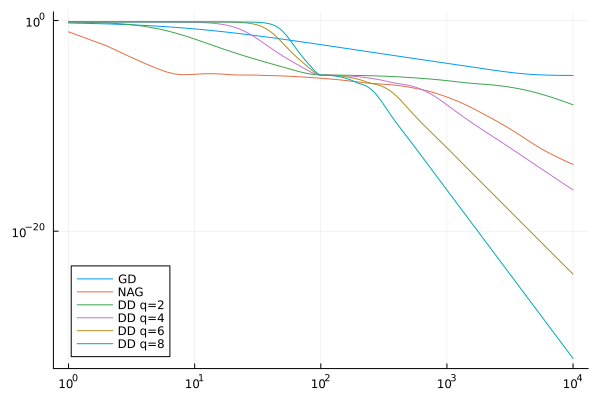

In [20]:
plot(losslst[1,:], label="GD", xscale=:log10, yscale=:log10)
plot!(losslst[2,:], label="NAG", xscale=:log10, yscale=:log10)
plot!(losslst[3,:], label="DD q=2", xscale=:log10, yscale=:log10)
plot!(losslst[4,:], label="DD q=4", xscale=:log10, yscale=:log10)
plot!(losslst[5,:], label="DD q=6", xscale=:log10, yscale=:log10)
plot!(losslst[6,:], label="DD q=8", xscale=:log10, yscale=:log10)
plot!(legend=:bottomleft)